In [32]:
# Script computes stream function in plain perpendicular to coastline

In [33]:
from netCDF4 import Dataset
import os
import numpy as np
import matplotlib.pyplot as plt
import decomp_alllevels as deco
from imp import reload
import write_netCDF as write
import amoc_plots as aplot
import tools
import xz_tools as xz_tools
import numpy.ma as ma
from scipy.interpolate import interp1d
import matplotlib.colors as mplc
import matplotlib.colors as colors

In [34]:
reload(tools)

<module 'tools' from '/home/mpim/m300522/mod_data/tools.py'>

In [35]:
########### CHOOSE CASE #########
case="10S"
#################################

########### CHOOSE TIME #########
time="2000s"
#################################

path=tools.case_path(case,time)
os.chdir(path)

## Load data and grid needed for streamfunction 

In [36]:
wrho = tools.netread_data('../wrho_eddy_stripe.nc','wrho_eddy') # wrho_eddy
divUrho = tools.netread_data("../div_Urho_eddy_stripe.nc","div_Urho_eddy") # eddy flux divergence
U_grad_rho = tools.netread_data("../U_grad_rho_stripe.nc","mean_advection_rho") # mean density advection
vke = tools.netread_data('../vke_p_stripe.nc','vke') # vke
uko = tools.netread_data('../uko_p_stripe.nc','uko') # vke
rho = tools.netread_data('../rhopoto_stripe.nc','rhopoto') # density
lat,lon,depth = tools.netread_grid('../rhopoto_stripe.nc','lat','lon','depth_14')
nx = tools.netread_data('../dxN_vel_hor_mag_stripe.nc','dx_vel_hor_mag') # normal vector x-comp
ny = tools.netread_data('../dyN_vel_hor_mag_stripe.nc','dy_vel_hor_mag') # normal vector y-comp
Pe2Pm_hor = tools.netread_data('../Pe2Pm_hor_stripe.nc','Pe2Pm') # conversion eddy to mean Pot energy
EKE_full = tools.netread_data('../EKE_full_stripe.nc','EKE_full')
dx_urho_eddy = tools.netread_data('../dx_urho_eddy_stripe.nc', 'dx_urho_eddy')
dy_vrho_eddy = tools.netread_data('../dy_vrho_eddy_stripe.nc', 'dy_vrho_eddy')
dz_wrho_eddy = tools.netread_data('../dz_wrho_eddy_stripe.nc', 'dz_wrho_eddy')
wo_p = tools.netread_data('../wo_p_stripe.nc', 'wmo')

ztop 	= 600.
zbot	= 3600.

ktop,kbot,k2k = tools.depths_xz_sections(ztop,zbot,depth)

lx,rx,llon,rlon= tools.case_region_meancirc(case)

lat2 = lat[:,lx:rx]
lon2 = lon[:,lx:rx]
#urho_eddy2 = urho_eddy[:,:,lx:rx]
#vrho_eddy2 = vrho_eddy[:,:,lx:rx]
wrho2 = wrho[:,:,lx:rx]
vke2 = vke[:,:,lx:rx]
uko2 = uko[:,:,lx:rx]
rho2 = rho[:,:,lx:rx]
divUrho2 = divUrho[:,:,lx:rx]
nx2 = 1*nx[:,:,lx:rx]
ny2 = 1*ny[:,:,lx:rx]
U_grad_rho2 = 1*U_grad_rho[:,:,lx:rx]
Pe2Pm_hor2 = 1*Pe2Pm_hor[:,:,lx:rx]
EKE_full2 = 1*EKE_full[:,:,lx:rx]
dx_urho_eddy2 = 1*dx_urho_eddy[:,:,lx:rx]
dy_vrho_eddy2 = 1*dy_vrho_eddy[:,:,lx:rx]
dz_wrho_eddy2 = 1*dz_wrho_eddy[:,:,lx:rx]
wo_p2 = 1*wo_p[:,:,lx:rx]

llon2 = llon-lx
rlon2 = llon-lx + (rlon -llon)

dist = np.zeros((lon[0,llon:rlon].shape))
for i in range(len(dist)):
    dist[i] = i * 11.113
    # Get distance from coast from lon:

x,z = np.meshgrid(dist,depth[ktop:kbot])
clines2,maxpos = tools.clines_from_uko_vke(kbot,ktop,k2k,uko,uko2,vke2)

/sw/rhel6-x64/python/python-3.5.2-gcc49/lib/python3.5/site-packages/numpy-1.11.2-py3.5-linux-x86_64.egg/numpy/ma/core.py:6457: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


## Get normals and decomposition

In [37]:
#tangent, normal = deco.get_normals_sophisticated(clines2,lat2,lon2)
#upar,uper = deco.decomposition(uko2,vke2,tangent,normal,lon2,lat2,clines2,ktop,kbot)
#tangent, normal = deco.get_normals_dd(lat2,lon2,ktop,kbot,uko2,vke2)
#tangent, normal = deco.get_normals(clines2,lat2,lon2,ktop,kbot)
#upar,uper,minimalj = deco.decomposition_little_sophisticated(uko2,vke2,tangent,normal,lon2,lat2,clines2,ktop,kbot)
# to reference cdepth you always have to substract 20 depth[ktop]=cdepth[ktop-20]
normal, tangent = deco.read_normal_get_tangent(nx2,ny2,clines2,k2k)
upar,uper,minimalj = deco.decomposition_little_sophisticated(uko2,vke2,tangent,normal,lon2,lat2,clines2,ktop,kbot)

/sw/rhel6-x64/python/python-3.5.2-gcc49/lib/python3.5/site-packages/numpy-1.11.2-py3.5-linux-x86_64.egg/numpy/ma/core.py:3158: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/sw/rhel6-x64/python/python-3.5.2-gcc49/lib/python3.5/site-packages/numpy-1.11.2-py3.5-linux-x86_64.egg/numpy/ma/core.py:3174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  elif _mask is not nomask and _mask[indx]:


In [44]:
reload(xz_tools)
lat_from = -10
lat_to = -15
#mean_upar,data_upar = xz_tools.along_average(upar,upar,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
#mean_uper,data_uper = xz_tools.along_average(upar,uper,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
#mean_wo_p,data_wo_p = xz_tools.along_average(upar,wo_p2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
mean_rho,data_rho = xz_tools.along_average(upar,rho2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)


mean_upar,data_upar = xz_tools.along_average_dd(uko2,vke2,upar,ktop,kbot,k2k,llon2,rlon2,maxpos,lat,lat_from,lat_to)
mean_uper,data_uper = xz_tools.along_average_dd(uko2,vke2,uper,ktop,kbot,k2k,llon2,rlon2,maxpos,lat,lat_from,lat_to)
mean_wo_p,data_wo_p = xz_tools.along_average_dd(uko2,vke2,wo_p2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat,lat_from,lat_to)

mean_uko,data_uko = xz_tools.along_average(upar,uko2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
mean_vke,data_vke = xz_tools.along_average(upar,vke2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)

data_rho_ = data_rho.copy()
data_rho  = np.ma.masked_where(data_rho == 0, data_rho_,copy=True)

data_upar = tools.mask_according_to(data_rho,data_upar)
data_uper = tools.mask_according_to(data_rho,data_uper)
data_wo_p = tools.mask_according_to(data_rho,data_wo_p)

/sw/rhel6-x64/python/python-3.5.2-gcc49/lib/python3.5/site-packages/numpy-1.11.2-py3.5-linux-x86_64.egg/numpy/ma/core.py:6457: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


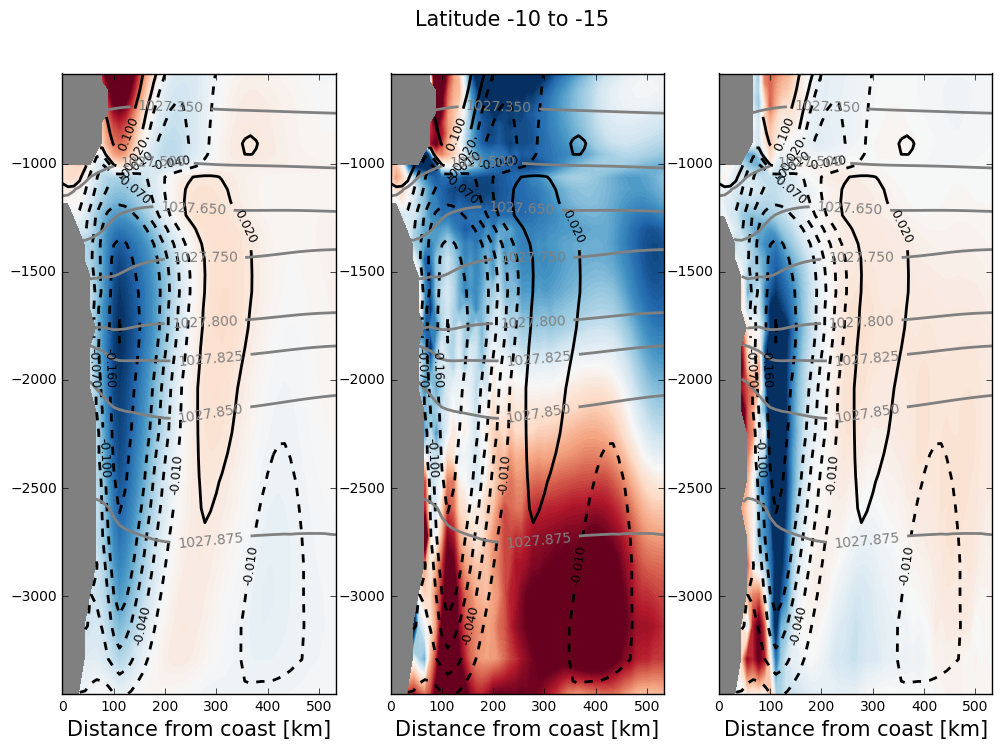

In [45]:
fig = plt.figure(figsize=(12,8))
fig.suptitle("Latitude " + str(lat_from) + " to " + str( lat_to ),fontsize=15)
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

high=0.2
v =  np.linspace(-high,high,100)
tools.plot_rho_upar(ax1,x,z,data_upar,data_rho,'along','left')
fdat1=ax1.contourf(x,-z,data_upar,v,extend="both",cmap='RdBu_r')

high=0.01
v =  np.linspace(-high,high,100)
tools.plot_rho_upar(ax2,x,z,data_upar,data_rho,'across','center')
fdat2=ax2.contourf(x,-z,data_uper,v,extend="both",cmap='RdBu_r')

high=5e-5
v =  np.linspace(-high,high,100)
tools.plot_rho_upar(ax3,x,z,data_upar,data_rho,'vertical','right')
fdat3=ax3.contourf(x,-z,data_wo_p,v,extend="both",cmap='RdBu_r')

plt.show()

In [46]:
reload(tools)

<module 'tools' from '/home/mpim/m300522/mod_data/tools.py'>

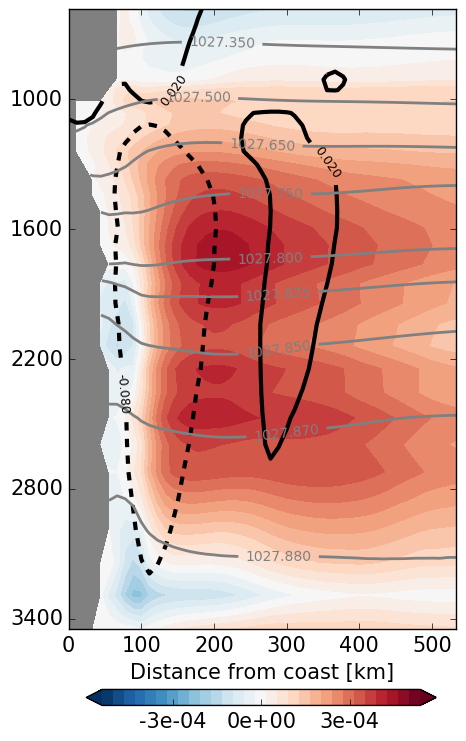

In [47]:
fig = plt.figure(figsize=(5,8))
#fig.suptitle("Latitude " + str(lat_from) + " to " + str( lat_to ),fontsize=15)
ax1 = fig.add_subplot(1,1,1)

sum_wo_p = np.zeros((data_wo_p.shape))
for i in range(1,data_wo_p.shape[1]):
    sum_wo_p [:,i] = sum_wo_p[:,i-1] + data_wo_p[:,i]

sum_wo_p_ = ma.masked_where(sum_wo_p==0,-sum_wo_p,copy=False)

data_ = sum_wo_p_.copy()
sum_wo_p_ =  np.ma.masked_where(data_rho.mask==True, data_, copy=True)

high=4.5e-4
v =  np.linspace(-high,high,30)
plt.yticks((-1000,-1600,-2200,-2800,-3400),(1000,1600,2200,2800,3400),fontsize=15)
plt.xticks(fontsize=15)
tools.plot_rho_upar_meancirc(ax1,x,z,data_upar,data_rho,'Streamfunction')
fdat1=ax1.contourf(x,-z,sum_wo_p_[:,:],v,extend="both",cmap='RdBu_r')
tools.plot_colorbar_all(fig,ax1,fdat1)


plt.savefig("/work/mh0256/m300522/data_storm/eddies/2000s/figs/divUrho/mean_streamfunction"+str(np.int64(lat_from))+"to"+str(np.int64(lat_to))+".png",bbox_inches = 'tight')


plt.show()

In [43]:
lat_from

-13